# Intro to AI Tutorial - Week 2
## Amir Mohseni - i6356969

This notebook is part of the ongoing Introduction to AI tutorial series. It builds on the material covered in the tutorial from last week, where we explored logistic regression models for predicting accidents and heart attacks using various features like alertness, hypertension, and others. You can view the previous notebook here: [Intro to AI Tutorials - Week 1](https://github.com/Amir-Mohseni/Intro_to_AI_Tutorials/blob/main/W1/AI_Tutorial_W1.ipynb)

# 1. Read the data

In [1]:
import pandas as pd

# Convert to df
train_set = pd.read_csv('/content/set2_500_patients.csv')
test_set = pd.read_excel('/content/set3_500_patients.xlsx')

## Formatting the data

In [2]:
boolean_columns = ['accident', 'heart_attack']
action_mapping = {
    'coffee': 0,
    'sleep': 1,
    'alcohol': 2,
    'nothing': 3,
    'work': 4,
    'patient died': 5
}


for df in [train_set, test_set]:
  df.drop('Unnamed: 0', axis=1, errors='ignore', inplace=True)  # Drop 'Unnamed: 0' if it exists
  df['action'] = df['action'].map(action_mapping)  # Apply the mapping to the 'action' column

  """
  # One-hot encoding
  df_one_hot = pd.get_dummies(df['action'], prefix='action')
  df = df.join(df_one_hot)  # Join the one-hot encoded columns to the original DataFrame
  df.drop('action', axis=1, inplace=True)  # Optionally drop the original 'action' column
  """
  # Convert boolean columns to 0 and 1
  for col in boolean_columns:
      df[col] = df[col].apply(lambda x: 1 if x is True else 0)

In [3]:
len(train_set)

344065

In [4]:
train_set.head()

,day,hour,action,alertness,hypertension,intoxication,heart_attack,accident,smoker,overweight,family_history,goof_ball,subject
0,0,0,0,1.394465,0.114070,0.0,0,0,0.671647,0.730691,0.322668,0.653565,0
1,0,1,1,0.774357,0.067966,0.0,0,0,0.671647,0.730691,0.322668,0.653565,0
2,0,2,1,1.281268,0.040496,0.0,0,0,0.671647,0.730691,0.322668,0.653565,0
3,0,3,1,1.123732,0.024128,0.0,0,0,0.671647,0.730691,0.322668,0.653565,0
4,0,4,1,1.247691,0.014376,0.0,0,0,0.671647,0.730691,0.322668,0.653565,0


In [5]:
test_set.head()

,day,hour,action,alertness,hypertension,intoxication,heart_attack,accident,smoker,overweight,family_history,goof_ball,subject
0,0,0,4,1.127998,0.000000,0.00000,0,0,0.708133,0.838291,0.300351,0.920894,0
1,0,1,1,0.819486,0.000000,0.00000,0,0,0.708133,0.838291,0.300351,0.920894,0
2,0,2,1,0.685674,0.000000,0.00000,0,0,0.708133,0.838291,0.300351,0.920894,0
3,0,3,1,1.147203,0.000000,0.00000,0,0,0.708133,0.838291,0.300351,0.920894,0
4,0,4,2,1.121604,0.236082,0.01741,0,0,0.708133,0.838291,0.300351,0.920894,0


# 2. Forecasting activity from a sequence of past activities
Firstly, we need to create a model that when we give it a sequence of past actions, it can predict the next action. This similar to how models like ChatGPT and Gemini work.

There are two ways we can do this.
1. We have sequences of fixed length. (Length = Tx)
2. We have sequences of variable lenght (Length <= Tx)

In our approach, we can set a fixed length and work with that since we don't have a restriction regarding that. When predicting such sequences, we have several options. RNNs, LSTMs, and Auto Regressive models. The way we pick between them is with the amount of data we have, the size of the model, accuracy we want, and the computing resources. In this task, since we have enough data (We don't need to use Auto-regressive models), and we want good acccuracy and for the model to use data from most of the sequence given, we can use a LSTM model.
## Creating sequences
To start, we need to convert the train/test data into sequences to start working on it and training the model.
We first create the training data from the current data by grouping the data based on their subject/patient. Afterwards, we create data only for each patient to not have any useless or unhelpful data. To avoid contaminations, we seperate train and dev tests based on the subject before training.

In [6]:
import numpy as np

# Function to create sequences for each subject
def create_sequences(data, sequence_length):
    sequences = []
    targets = []

    for subject_id in data['subject'].unique():
        subject_data = data[data['subject'] == subject_id]  # Filter by subject
        actions = subject_data['action'].values  # Extract the sequence of actions

        for i in range(len(actions) - sequence_length):
            seq = actions[i:i + sequence_length]  # Get the sequence of actions
            target = actions[i + sequence_length]  # Get the next action
            sequences.append(seq)
            targets.append(target)

    return np.array(sequences), np.array(targets)

To split the training data set, we first split the patients using a 90/10 train/dev split. Afterwards, we create the training and validation data by adding each row to their respective patient using their subject column. This ensures that we don't have any cross contamination within the data.

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

# Define the sequence length
sequence_length = 70

# Split based on subjects first (from train_set only)
subjects = train_set['subject'].unique()

# Split subjects into 80% train and 20% validation
train_subjects, val_subjects = train_test_split(subjects, test_size=0.1, random_state=42)

# Create training and validation sets based on subjects
train_data = train_set[train_set['subject'].isin(train_subjects)]
val_data = train_set[train_set['subject'].isin(val_subjects)]

In [9]:
# Create sequences for the train and validation sets
X_train, y_train = create_sequences(train_data, sequence_length)
X_val, y_val = create_sequences(val_data, sequence_length)

# Create sequences for the test set
X_test, y_test = create_sequences(test_set, sequence_length)

## Creation, and Training of the LSTM model
In this task, we use tensorflow which is developed by Google to help developers create neural networks with ease with a lot of abstraction. We use to layers of LSTM in this model, after testing with one layer and two layers, I saw much better results with two layers.

Since we are trying to predict the next action, we use a softmax layer at the end which is similar to how a sigmoid function works but for several classes instead of just one.

Training these models are possible on the CPU, however, it might take a long time, in these circumstances, we can use GPUs which for training of this model, I used Nvidia T4 to use the power and efficiency of NVIDA CUDA.

In addition, I used the Adam optimizer which is shown to improve results and is widely used in training NNs.

To speed up the process, I used a batch size of 4096, which helps the model do more things in parallel, but might make it harder for the model to generalize. In addition, I chose a epoch of 20, which helped each senario to be seen enough times for the model to learn.

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

# Optional: Force the model to use GPU (if available)
with tf.device('/GPU:0'):  # Use '/GPU:1' if you have multiple GPUs
  # Parameters
  n_unique_actions = 6  # Number of unique actions
  embedding_dim = 50  # Size of embedding vectors

  # Model
  model = Sequential()
  model.add(Embedding(input_dim=n_unique_actions, output_dim=embedding_dim))
  model.add(LSTM(128, return_sequences=True))  # Return sequences to feed the next LSTM layer
  model.add(LSTM(64, return_sequences=False))  # Second LSTM layer with fewer units
  model.add(Dense(n_unique_actions, activation='softmax'))  # Output layer

  # Compile the model
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=4096, validation_data=(X_val, y_val))

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.4298 - loss: 1.4527 - val_accuracy: 0.5859 - val_loss: 1.0582
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.5652 - loss: 1.0837 - val_accuracy: 0.6014 - val_loss: 0.9919
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.5763 - loss: 1.0360 - val_accuracy: 0.6030 - val_loss: 0.9770
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.5775 - loss: 1.0200 - val_accuracy: 0.6089 - val_loss: 0.9552
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.5847 - loss: 1.0009 - val_accuracy: 0.6077 - val_loss: 0.9518
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - accuracy: 0.5855 - loss: 0.9921 - val_accuracy: 0.6069 - val_loss: 0.9538
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.5867 - loss: 0.9901 - val_accuracy: 0.6107 - val_loss: 0.9363
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - accuracy: 0.5877 - loss: 0.9816 - val_accu

### Example

In [12]:
# Example prediction
rand_example = 30
example_sequence = X_train[rand_example].reshape(1, -1)  # Use a sequence from the training data
predicted_action = model.predict(example_sequence)
predicted_action = np.argmax(predicted_action)  # Get the index of the most likely action

print(f"Predicted action: {predicted_action}")
print(f"Actual action: {y_train[rand_example]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Predicted action: 1
Actual action: 1


## Results
After training and testing we can see that this model will perform correctly with an accuracy of around **60%** both on training and test data. This means that the model hugely outperforms random guessing which means our model actually learned from the data. (random guessing = 16.66%)

In [13]:
# Predict on validation set
y_pred = model.predict(X_test)

# Convert predictions to class labels (actions)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy manually
accuracy = np.mean(y_pred_classes == y_test)
print(f"Manual Accuracy: {accuracy * 100:.2f}%")

9565/9565 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step
Manual Accuracy: 59.57%


## Visualization
We use a Confusion matrix, to view how the model predicted the labels and to see if there are some easy-to-identify biases in the model.

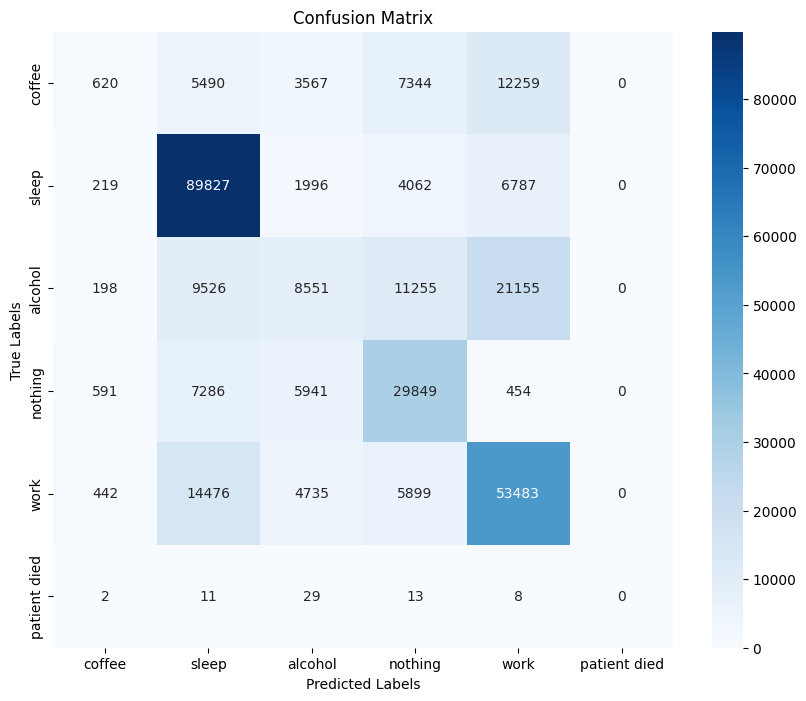

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # Import the confusion_matrix function

# Assuming you have y_true and y_pred defined (e.g., from your model predictions)
conf_matrix = confusion_matrix(y_test, y_pred_classes) # Calculate the confusion matrix

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(action_mapping.keys()), yticklabels=list(action_mapping.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# 3. Prediction of the activity class

Now, we try to predict the actions using the other data's provided for each row. To do so, like the prediction for accidents and heart attacks, we use **Logistic Regression**.

## Import Libraries

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Model Training
We train this model using the sklearn library. Afterwards, we test the model on our test set. Since we need to classify the data into several classes, logistic regression does pretty good in this task.

In [39]:
# Extracting the features and target
X = train_set.drop('action', axis=1)  # All columns except 'action'
y = train_set['action']  # Target (Action)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Logistic Regression model (you can try other classifiers too)
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report (precision, recall, f1-score for each class)
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Accuracy: 45.78%
Confusion Matrix:
[[ 2109  2502  1173    76  1058     0]
 [   29 19291   462   886  2626     0]
 [  591  2221  4609   246  3542     0]
 [  746  4014  1687   549  2710     0]
 [ 1078  8898  2363   393  4946     0]
 [    3     0     5     0     0     0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.30      0.37      6918
           1       0.52      0.83      0.64     23294
           2       0.45      0.41      0.43     11209
           3       0.26      0.06      0.09      9706
           4       0.33      0.28      0.30     17678
           5       0.00      0.00      0.00         8

    accuracy                           0.46     68813
   macro avg       0.34      0.31      0.31     68813
weighted avg       0.42      0.46      0.41     68813



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

## Results
The model does pretty well since we are classifying data into 6 classes. (Better than random chance by a significant margin), however, since the model cannot use the data from several rows at the same time, it seems to not be able to do as good as a job that the LSTM method did.

We can conclude that for classification/prediction for a row value, this method might be a good method, however, for predicting using several rows and predicting the next one, we can use models designed for those tasks like RNNs, LSTM, Transformers(overkill for such a task).

### Confusion Matrix
To understand the model on a deeper level, we can use the confusion matrix since it helps us understand the biases and shortcomings of the model. This method is very helpfull when we are working with classification problems.

We can see that the model is very good at predicting when user is sleep which might indicate that the difference between a sleeping patient and a non-sleeping patient is significant enough for the model to understand and correctly predict.

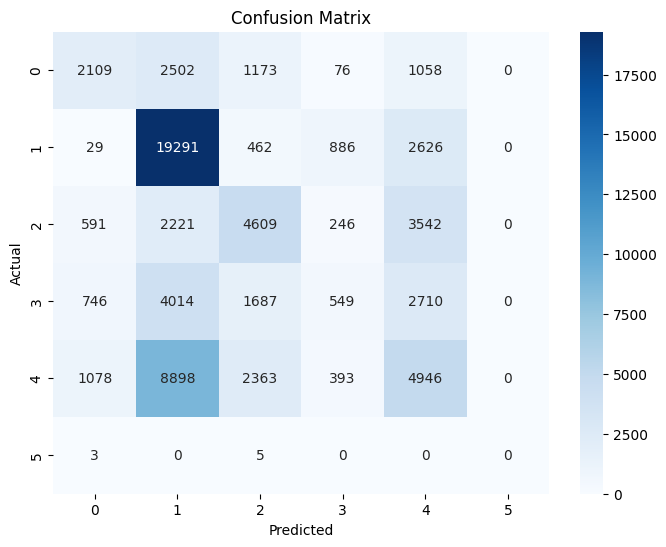

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [41]:
# Extract features (X_test) and target (y_test) from test_set
X_test_set = test_set.drop('action', axis=1)  # All columns except 'action'
y_test_set = test_set['action']  # Target (Action)

# Predict on the test set
y_pred_test_set = model.predict(X_test_set)

# Evaluate the model on test_set
test_accuracy = accuracy_score(y_test_set, y_pred_test_set)
print(f"Test Set Accuracy: {test_accuracy * 100:.2f}%")

# Confusion Matrix for test_set
test_conf_matrix = confusion_matrix(y_test_set, y_pred_test_set)
print("Test Set Confusion Matrix:")
print(test_conf_matrix)

# Classification Report for test_set
test_class_report = classification_report(y_test_set, y_pred_test_set)
print("Test Set Classification Report:")
print(test_class_report)

Test Set Accuracy: 45.40%
Test Set Confusion Matrix:
[[ 9394 12151  5996   364  5006     0]
 [  190 94202  2542  4017 12988     0]
 [ 2887 10956 23803  1423 17697     0]
 [ 3406 20498  8393  2633 14300     0]
 [ 4665 45449 11494  1757 24801     0]
 [   14     0    49     0     0     0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.29      0.35     32911
           1       0.51      0.83      0.63    113939
           2       0.46      0.42      0.44     56766
           3       0.26      0.05      0.09     49230
           4       0.33      0.28      0.30     88166
           5       0.00      0.00      0.00        63

    accuracy                           0.45    341075
   macro avg       0.34      0.31      0.30    341075
weighted avg       0.41      0.45      0.41    341075



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
